In [3]:
import matplotlib
import sys

sys.path.append('/media/avt1/0000678400004823/CKH/02_experiment/Distiller_Nova/examples/sr_model')

# Load some common jupyter code
%run distiller_jupyter_helpers.ipynb
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout
from models import create_model
from apputils import *
import torch
import pandas as pd

/home/avt1/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Choose to examine some models
prune_resume = '../C3SRCNN//C3SRCNN_cpr_all0.2_agp0.2.pth'
pruny_model = torch.load(prune_resume)

dense_resume = '../C3SRCNN/C3SRCNN_model_path.pth'
densy_model = torch.load(dense_resume)

models_dict = {'Dense': densy_model, 'Sparse': pruny_model}

/home/avt1/anaconda3/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'C3SRCNN.model.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/avt1/anaconda3/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'C3SRCNN.model.IRBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [164]:
def view_data(what, model_choice):
    df_sparsity = distiller.weights_sparsity_summary(models_dict[model_choice])
    # Remove these two columns which contains uninteresting values
    df_sparsity = df_sparsity.drop(['Cols (%)', 'Rows (%)'], axis=1)
    
    if what == 'Density':
        for granularity in ['Fine (%)', 'Ch (%)', '2D (%)', '3D (%)']:
            df_sparsity[granularity] = 100 - df_sparsity[granularity]
    display(df_sparsity)

display_radio = widgets.RadioButtons(options=['Sparsity', 'Density'], value='Sparsity', description='Display:')
model_dropdown = widgets.Dropdown(description='Model:', options=models_dict.keys(), value='Sparse')
interact(view_data, what=display_radio, model_choice=model_dropdown);

interactive(children=(RadioButtons(description='Display:', options=('Sparsity', 'Density'), value='Sparsity'),…

### View the element-wise sparsity of each layer

It is appearant that we removed 5 entire layers, all of which have only a few parameters.  If we wanted to reduce the footprint, then this is not a good choice of layers to remove.  Later on in the notebook we look at the compute metric and see the benefit of removing these layers.

/home/avt1/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


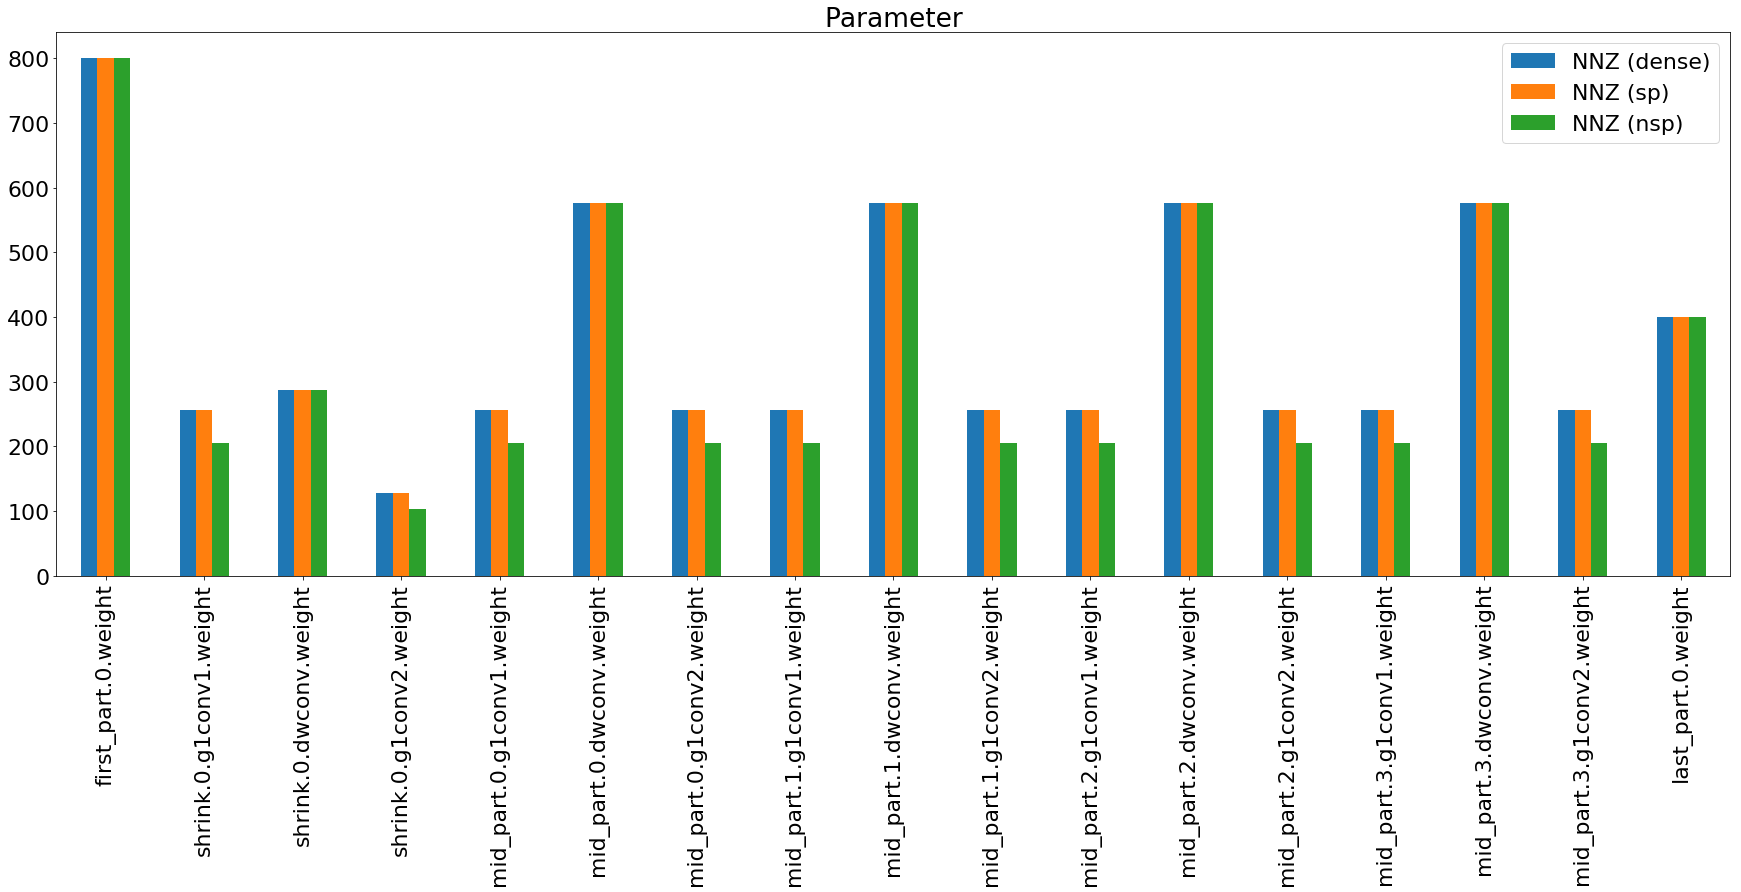

In [165]:
matplotlib.rcParams.update({'font.size': 22})

df_sparsity = distiller.weights_sparsity_summary(pruny_model)
df2_sparsity = df_sparsity[['NNZ (dense)', 'NNZ (sparse)']]
df2_sparsity.rename(columns={'NNZ (dense)': 'NNZ (sp)', 'NNZ (sparse)': 'NNZ (nsp)'}, inplace=True)

df_densy = distiller.weights_sparsity_summary(densy_model)
df2_densy = df_densy['NNZ (dense)']

df2_densy = pd.concat([df2_densy, df2_sparsity], axis=1)

ax = df2_densy.iloc[0:-1].plot(kind='bar', figsize=[30,10], title="Parameter")
ax.set_xticklabels(df_sparsity.Name, rotation=90);

### Compare the sparsity of different weight tensor sub-structures

Use the widget below to select the different structures who's sparsity you want to compare.<br>
You can choose multiple structures, to compare between them.
Ch (%) - this is the percentage of channels that are sparse<br>
2D (%) - this is the percentage of kernels that are sparse<br>
3D (%) - this is the percentage of filters that are sparse<br>
Fine (%) - this is the percentage of elements that are sparse<br>

In [38]:
def view(cols, what): 
    df_sparsity = distiller.weights_sparsity_summary(pruny_model)
    if what == 'Density':
        for granularity in ['Fine (%)', 'Ch (%)', '2D (%)', '3D (%)']:
            df_sparsity[granularity] = 100 - df_sparsity[granularity]
    
    df2 = df_sparsity[list(cols)]
    ax = df2.iloc[0:-1].plot(kind='bar', figsize=[30,10], title="Comparing structural sparsity", grid=True)
    ax.set_ylabel("% Sparsity")
    ax.set_xticklabels(df_sparsity.Name, rotation=90);


items = ['Ch (%)', '2D (%)', '3D (%)', 'Fine (%)']
cols_select = widgets.SelectMultiple(options=items, value=[items[1]])
display_radio = widgets.RadioButtons(options=['Sparsity', 'Density'], value='Sparsity', description='Display:')
interactive(view, cols=cols_select, what=display_radio)

interactive(children=(SelectMultiple(description='cols', index=(1,), options=('Ch (%)', '2D (%)', '3D (%)', 'F…

## Compare the distributions of the weight tensors in the sparse and dense models

We trained the sparse model with layer-wise regularization, but we can see that this affected the distibution of some of the layers.

Look at ```module.layer1.2.conv1.weight``` at an example of a weights tensor that is more "compact" after regularization.

In [182]:
from ipywidgets import *
import bqplot.pyplot as bqplt
from bqplot import Bars, Axis, Figure, LinearScale

xs = LinearScale()
ys = LinearScale()

xs_dense = LinearScale()
ys_dense = LinearScale()

nbins = 100
sparse_tensor = flatten(next (iter (pruny_model.state_dict().values())))
sparse_hist, sparse_edges = np.histogram(sparse_tensor, bins=nbins)
sparse_bar = Bars(x=sparse_edges, y=[sparse_hist], scales={'x': xs, 'y': ys}, padding=0.2, type='grouped')


dense_tensor = flatten(next (iter (densy_model.state_dict().values())))
dense_hist, dense_edges = np.histogram(dense_tensor, bins=nbins)
dense_bar = Bars(x=dense_edges, y=[dense_hist], scales={'x': xs_dense, 'y': ys_dense}, padding=0.2, type='grouped')

xax = Axis(scale=xs)
yax = Axis(scale=ys, orientation='vertical',  grid_lines='solid')

xax_dense = Axis(scale=xs_dense)
yax_dense = Axis(scale=ys_dense, orientation='vertical', grid_lines='solid')

f = Figure(marks=[sparse_bar], axes=[xax, yax], animation_duration=1000, title="Sparse")
f2 = Figure(marks=[dense_bar], axes=[xax_dense, yax_dense], animation_duration=1000, title="Dense")

shape =  distiller.size2str(next (iter (pruny_model.state_dict().values())).size())
param_info = widgets.Text(value=shape, description='shape:', disabled=True)

params_names = conv_fc_param_names(pruny_model)

weights_dropdown = Dropdown(description='weights', options=params_names)

def update(*args):
    sparse_model = pruny_model
    dense_model = densy_model
    
    param_name = weights_dropdown.value
    
    sparse_tensor = flatten(sparse_model.state_dict()[param_name])
    sparse_hist, sparse_edges = np.histogram(sparse_tensor, bins=nbins, density=False)
    sparse_bar.x = sparse_edges
    sparse_bar.y = sparse_hist
    
    dense_tensor = flatten(dense_model.state_dict()[param_name])
    dense_hist, dense_edges = np.histogram(dense_tensor, bins=nbins, density=False)
    dense_bar.x = dense_edges
    dense_bar.y = dense_hist
    shape =  distiller.size2str(dense_model.state_dict()[param_name].size())
    param_info.value = shape

weights_dropdown.observe(update, 'value')

VBox([HBox([weights_dropdown, param_info]), HBox([f, f2])])

## Performance metrics

Let's look at the compute performance metric of our channel-regularized model.  

To measure the MACs, we should look at the model after we have actually pruned the channels, because during this pruning process (which we call "model thinning"), we also remove the filters that produced the pruned channels.

In [5]:
batch_size = 1
dummy_input = Variable(torch.randn(1, 1, 224, 224), requires_grad=False)
df_channel_pruned = distiller.model_performance_summary(densy_model, dummy_input, batch_size)
# df_sparsity = distiller.weights_sparsity_summary(sparse_model)
#df['sparse MACs'] = df['MACs'] * (1 - df_sparsity['Ch (%)'] / 100)
display(df_channel_pruned)
resnet20_channel_pruned_MACs = df_channel_pruned['MACs'].sum()
print("Dense MACs: " + "{:,}".format(int(resnet20_channel_pruned_MACs)))

,Name,Type,Attrs,IFM,IFM volume,OFM,OFM volume,Weights volume,MACs
0,first_part.0,Conv2d,"k=(5, 5)","(1, 1, 224, 224)",50176,"(1, 32, 224, 224)",1605632,800,40140800
1,shrink.0,Conv2d,"k=(1, 1)","(1, 32, 224, 224)",1605632,"(1, 32, 224, 224)",1605632,1024,51380224
2,shrink.2,Conv2d,"k=(3, 3)","(1, 32, 224, 224)",1605632,"(1, 32, 224, 224)",1605632,9216,14450688
3,shrink.4,Conv2d,"k=(1, 1)","(1, 32, 224, 224)",1605632,"(1, 16, 224, 224)",802816,512,25690112
4,mid_part.0.g1conv1,Conv2d,"k=(1, 1)","(1, 16, 224, 224)",802816,"(1, 64, 224, 224)",3211264,1024,51380224
5,mid_part.0.dwconv,Conv2d,"k=(3, 3)","(1, 64, 224, 224)",3211264,"(1, 64, 224, 224)",3211264,36864,28901376
6,mid_part.0.g1conv2,Conv2d,"k=(1, 1)","(1, 64, 224, 224)",3211264,"(1, 16, 224, 224)",802816,1024,51380224
7,mid_part.1.g1conv1,Conv2d,"k=(1, 1)","(1, 16, 224, 224)",802816,"(1, 64, 224, 224)",3211264,1024,51380224
8,mid_part.1.dwconv,Conv2d,"k=(3, 3)","(1, 64, 224, 224)",3211264,"(1, 64, 224, 224)",3211264,36864,28901376
9,mid_part.1.g1conv2,Conv2d,"k=(1, 1)","(1, 64, 224, 224)",3211264,"(1, 16, 224, 224)",802816,1024,51380224


Dense MACs: 678,379,520


### Compare sparse model compute vs. dense model compute

In [179]:
prune_resume = '../C4SRCNN/C4SRCNN_cpr_agp0.5.pth'
pruny_model = torch.load(prune_resume)

dense_resume = '../C4SRCNN/C4SRCNN_model_path.pth'
densy_model = torch.load(dense_resume)

/home/avt1/anaconda3/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Dense MACs:  0.31G
Structured Prune MACs: 0.31G
	Ratio: 100.00 %
Non-Structured MACs: 0.25G
	Ratio: 80.26 %


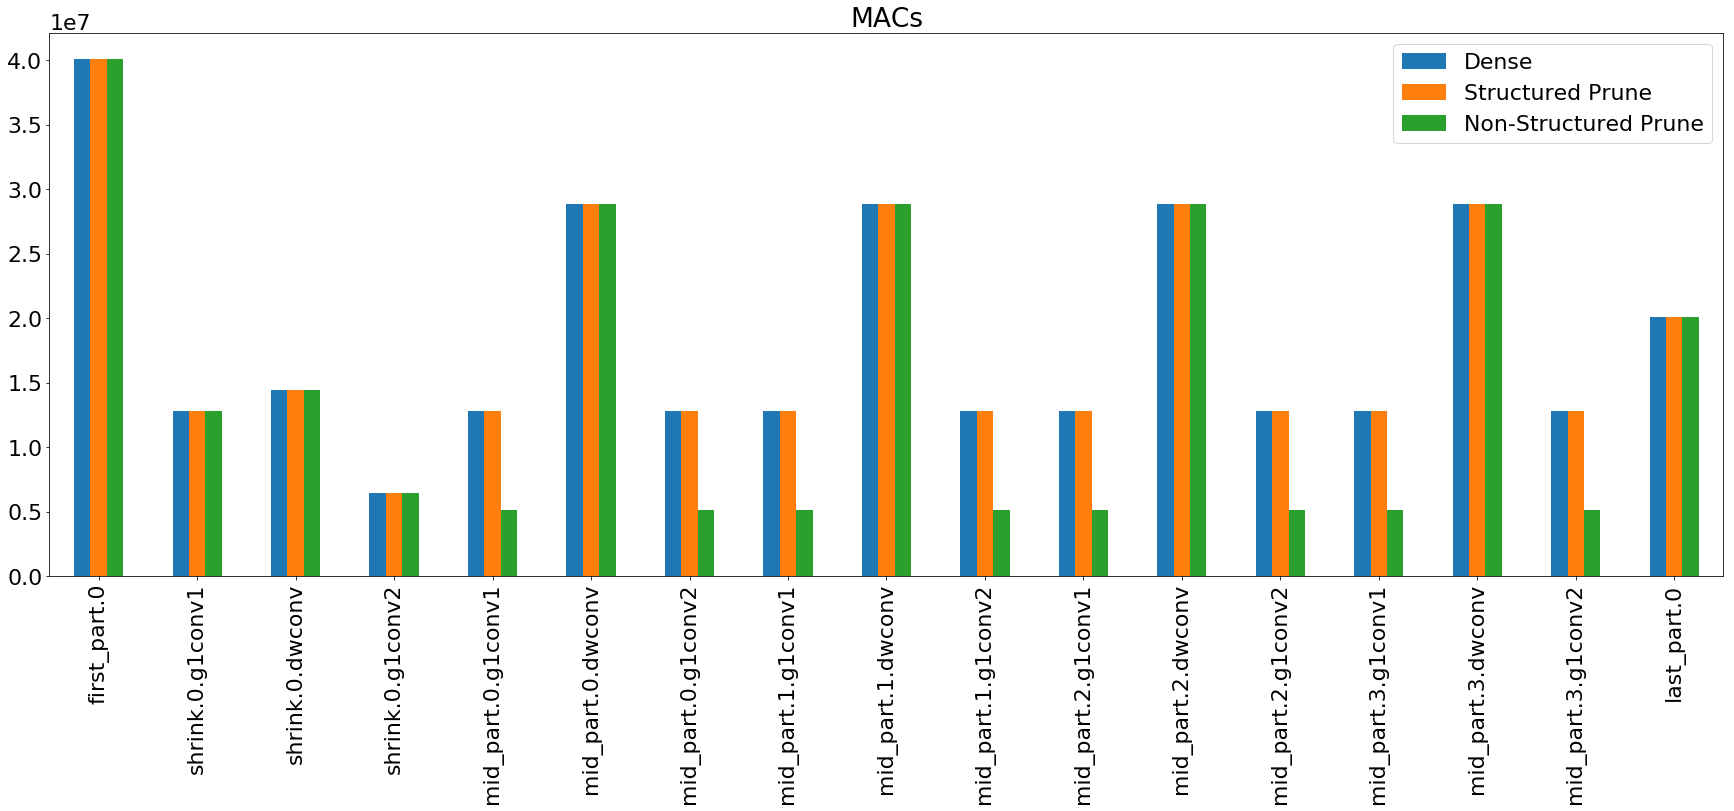

In [180]:
'''
nsp_list = {'shrink.0.g1conv1', 'shrink.0.g1conv2', 
            'mid_part.0.g1conv1', 'mid_part.0.g1conv2',
            'mid_part.1.g1conv1', 'mid_part.1.g1conv2',
            'mid_part.2.g1conv1', 'mid_part.2.g1conv2',
            'mid_part.3.g1conv1', 'mid_part.3.g1conv2'}
'''

'''
nsp_list = {'mid_part.0.0', 'mid_part.1', 'mid_part.2', 'mid_part.3',
            'mid_part.4', 'mid_part.6.0'}
'''

nsp_list = {'shrink.0', 'shrink.4', 'mid_part.0.g1conv1', 'mid_part.0.g1conv2',
            'mid_part.1.g1conv1', 'mid_part.1.g1conv2',
            'mid_part.2.g1conv1', 'mid_part.2.g1conv2',
            'mid_part.3.g1conv1', 'mid_part.3.g1conv2'}

nsp_ratio = 0.6

df_dense = distiller.model_performance_summary(densy_model, dummy_input, batch_size)
dense_MACs = df_dense['MACs'].sum()

df_sp = distiller.model_performance_summary(pruny_model, dummy_input, 1)
sp_MACs = df_sp['MACs'].sum()

df_nsp = df_sp.copy()
for layer in nsp_list:
    df_nsp.loc[df_nsp['Name'] == layer, 'MACs'] = df_nsp.loc[df_nsp['Name'] == layer, 'MACs']*(1-nsp_ratio)
nsp_MACs = df_nsp['MACs'].sum()


print("Dense MACs:  %.2fG" % (dense_MACs/1e9))
print("Structured Prune MACs: %.2fG" % (sp_MACs/1e9))
print("\tRatio: %.2f %%" % (sp_MACs / dense_MACs * 100))

print("Non-Structured MACs: %.2fG" % (nsp_MACs/1e9))
print("\tRatio: %.2f %%" % (nsp_MACs / dense_MACs * 100))


df_compute = pd.concat({'Dense': df_dense['MACs'], 
                        'Structured Prune': df_sp['MACs']
                       }, axis=1)
df_compute = pd.concat([df_compute,df_nsp['MACs']], axis=1)
df_compute.rename(columns={'MACs': 'Non-Structured Prune'}, inplace=True)

ax = df_compute.plot.bar(figsize=[30,10], title="MACs");
ax.set_xticklabels(df_sp.Name, rotation=90);